# 01_data_build_colored
- Author: 정재훈
- Date: 2025-11-10
- Goal: Colored MNIST 생성(색/배경 옵션)
- Input: 
- Output: 
- Metrics: acc@val, loss@train
- Repro: seed=42, device=auto, config=../configs/


In [2]:
# ======================================
# Cell 1. Imports & global config
# ======================================

import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from scipy.ndimage import shift, rotate, affine_transform
from PIL import Image, ImageDraw, ImageFont

plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams["axes.grid"] = False

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("[INFO] Libraries imported.")

[INFO] Libraries imported.


In [3]:
# ======================================
# Cell 2. Paths & augmentation settings
# ======================================
# Assume this notebook is located at the project root
BASE_DIR = os.getcwd()

# Raw data dirs
RAW_DATA_DIR = os.path.join(BASE_DIR, "data", "raw")
RAW_MNIST_DIR = os.path.join(RAW_DATA_DIR, "mnist")
RAW_FONTS_DIR = os.path.join(RAW_DATA_DIR, "fonts")

# MNIST train npz path
MNIST_TRAIN_PATH = os.path.join(RAW_MNIST_DIR, "mnist_train.npz")

# Processed output dir
PROC_DIR = os.path.join(BASE_DIR, "data", "processed", "colored_mnist")
os.makedirs(PROC_DIR, exist_ok=True)

# Final output npz path (100k total, train/val split)
SAVE_PATH = os.path.join(PROC_DIR, "colored_mnist_100k_train_val.npz")

# Augmentation sizes: 60k (raw) + 20k (deskew) + 10k (font) + 10k (shift+rotation) = 100k
DESKEW_AUG_TARGET = 20_000
FONT_AUG_TARGET   = 10_000
GEOM_AUG_TARGET   = 10_000
TARGET_TOTAL_SAMPLES = 60_000 + DESKEW_AUG_TARGET + FONT_AUG_TARGET + GEOM_AUG_TARGET

print("[INFO] BASE_DIR         :", BASE_DIR)
print("[INFO] MNIST_TRAIN_PATH :", MNIST_TRAIN_PATH)
print("[INFO] RAW_FONTS_DIR    :", RAW_FONTS_DIR)
print("[INFO] PROC_DIR         :", PROC_DIR)
print("[INFO] DESKEW_AUG_TARGET:", DESKEW_AUG_TARGET)
print("[INFO] FONT_AUG_TARGET  :", FONT_AUG_TARGET)
print("[INFO] GEOM_AUG_TARGET  :", GEOM_AUG_TARGET)

# Fixed color palette (ROYG BIV) – exactly as specified
COLOR_PALETTE = np.array([
    [255,   0,   0],  # Red
    [255, 144,   0],  # Orange
    [255, 220,   0],  # Yellow
    [  0, 255,   0],  # Green
    [  0,   0, 255],  # Blue
    [ 25,   0, 120],  # Indigo
    [110,   0, 180],  # Violet
], dtype=np.uint8)

N_COLORS   = COLOR_PALETTE.shape[0]
IMG_HEIGHT = 28
IMG_WIDTH  = 28

[INFO] BASE_DIR         : c:\Users\CHOI\colored-mnist-classification\notebooks
[INFO] MNIST_TRAIN_PATH : c:\Users\CHOI\colored-mnist-classification\notebooks\data\raw\mnist\mnist_train.npz
[INFO] RAW_FONTS_DIR    : c:\Users\CHOI\colored-mnist-classification\notebooks\data\raw\fonts
[INFO] PROC_DIR         : c:\Users\CHOI\colored-mnist-classification\notebooks\data\processed\colored_mnist
[INFO] DESKEW_AUG_TARGET: 20000
[INFO] FONT_AUG_TARGET  : 10000
[INFO] GEOM_AUG_TARGET  : 10000


[INFO] Keys in mnist_train.npz: ['train_images', 'train_labels']
[INFO] Raw MNIST shape (N, H, W): (60000, 28, 28)
[INFO] Raw labels shape         : (60000,)
[INFO] Unique labels            : [0 1 2 3 4 5 6 7 8 9]

[EDA] Digit label counts (raw):
0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
Name: count, dtype: int64


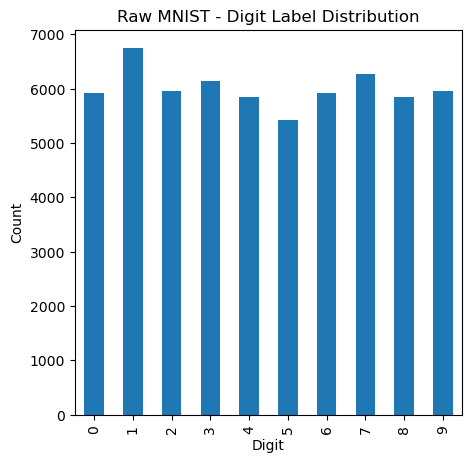

[EDA] Pixel min/max (raw): 0.0 / 255.0
[EDA] Pixel mean/std (raw): 33.32 / 78.57


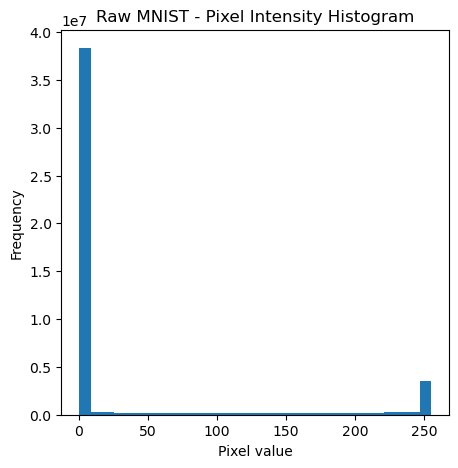

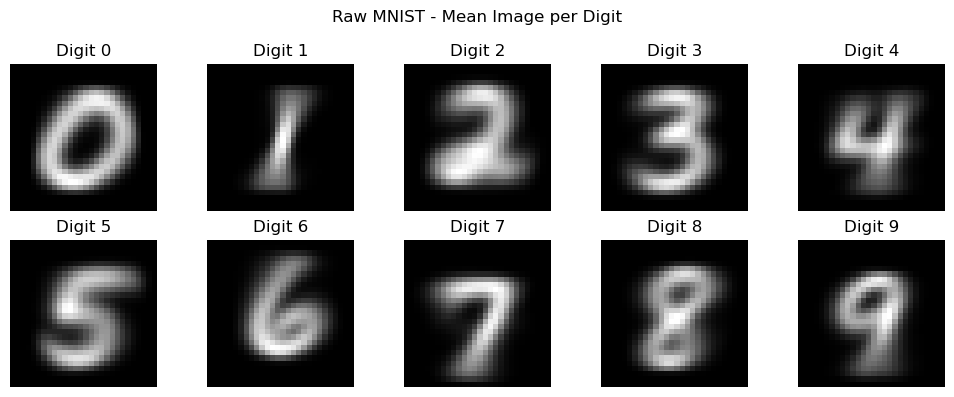

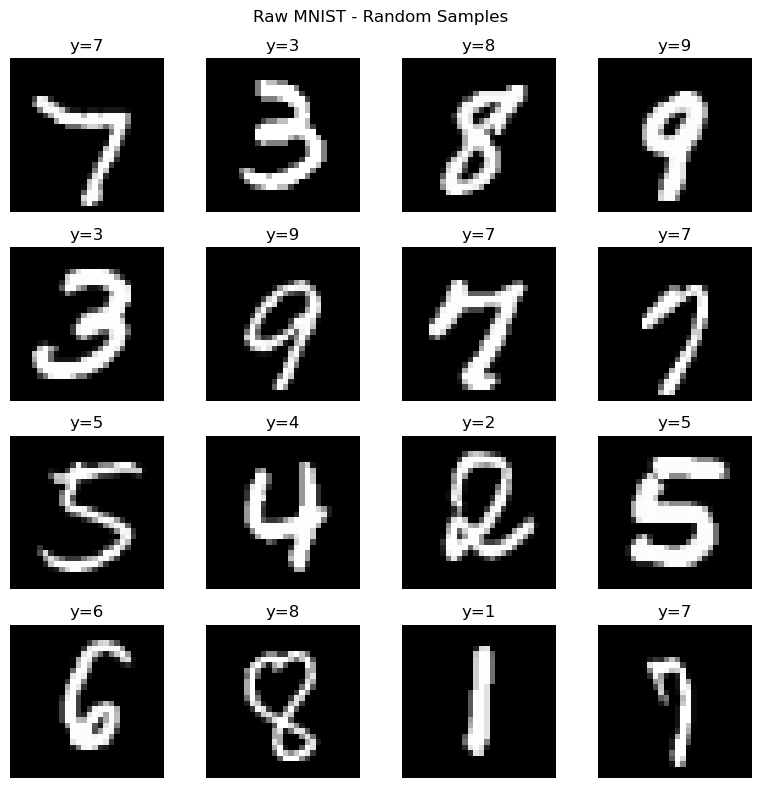

In [4]:
# ======================================
# Cell 3. Load raw MNIST (train_images / train_labels) + basic EDA
# ======================================
def load_mnist_npz(npz_path: str):
    """
    Load MNIST from mnist_train.npz with keys:
      - train_images: (60000, 28, 28), uint8
      - train_labels: (60000,), int64
    Returns:
      X: (N, 28, 28), float32
      y: (N,), int64
    """
    data = np.load(npz_path)
    print("[INFO] Keys in mnist_train.npz:", data.files)

    if "train_images" not in data.files or "train_labels" not in data.files:
        raise ValueError("Expected keys 'train_images' and 'train_labels' in mnist_train.npz.")

    X = data["train_images"].astype(np.float32)  # (N, 28, 28)
    y = data["train_labels"].astype(np.int64)   # (N,)
    if X.ndim != 3 or X.shape[1:] != (28, 28):
        raise ValueError(f"Unexpected train_images shape: {X.shape}")

    return X, y


X_raw, y_raw = load_mnist_npz(MNIST_TRAIN_PATH)

N_BASE = X_raw.shape[0]
print(f"[INFO] Raw MNIST shape (N, H, W): {X_raw.shape}")
print(f"[INFO] Raw labels shape         : {y_raw.shape}")
print(f"[INFO] Unique labels            : {np.unique(y_raw)}")

# --- EDA: label distribution (raw) ---
label_counts = pd.Series(y_raw).value_counts().sort_index()
print("\n[EDA] Digit label counts (raw):")
print(label_counts)

plt.figure()
label_counts.plot(kind="bar")
plt.title("Raw MNIST - Digit Label Distribution")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()

# --- EDA: pixel statistics (raw) ---
flat_pixels = X_raw.reshape(-1)
print(f"[EDA] Pixel min/max (raw): {flat_pixels.min()} / {flat_pixels.max()}")
print(f"[EDA] Pixel mean/std (raw): {flat_pixels.mean():.2f} / {flat_pixels.std():.2f}")

plt.figure()
plt.hist(flat_pixels, bins=30, range=(0, 255))
plt.title("Raw MNIST - Pixel Intensity Histogram")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.show()

# --- EDA: class-wise mean images (raw) ---
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
fig.suptitle("Raw MNIST - Mean Image per Digit", fontsize=12)
for d in range(10):
    mean_img = X_raw[y_raw == d].mean(axis=0)
    ax = axes[d // 5, d % 5]
    ax.imshow(mean_img, cmap="gray")
    ax.set_title(f"Digit {d}")
    ax.axis("off")
plt.tight_layout()
plt.show()

# --- EDA: random samples (raw) ---
def plot_random_digits(X, y, n=16, title="Random Raw Digits"):
    """
    Plot random digit images from the dataset.
    """
    idx = np.random.choice(len(X), size=n, replace=False)
    cols = 4
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(cols * 2, rows * 2))
    for i, j in enumerate(idx):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(X[j], cmap="gray")
        plt.title(f"y={y[j]}")
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_random_digits(X_raw, y_raw, n=16, title="Raw MNIST - Random Samples")

[INFO] Deskew-augmented shape: (20000, 28, 28)

[EDA] Pixel mean/std (raw)       : 33.32 / 78.57
[EDA] Pixel mean/std (deskew_aug): 33.44 / 76.35


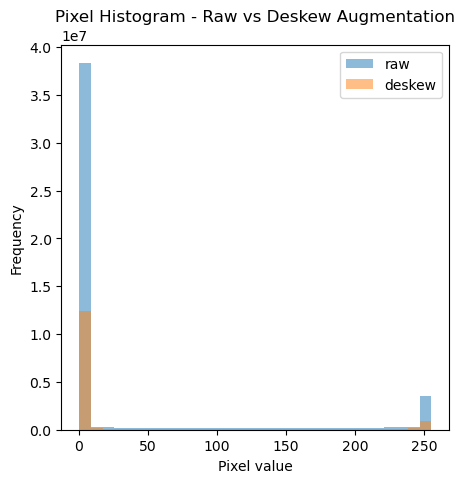

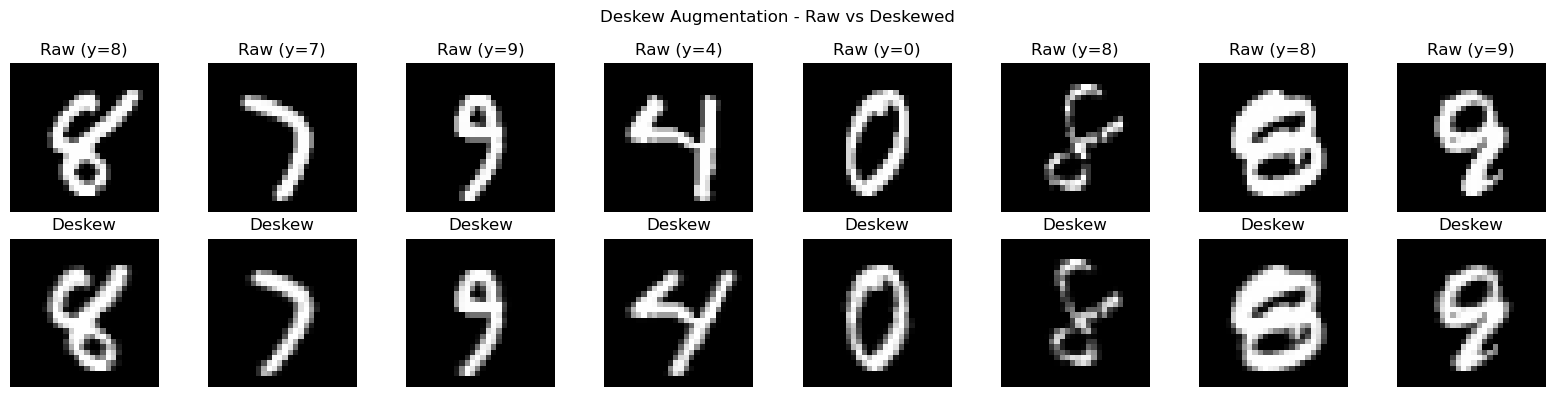

In [5]:
# ======================================
# Cell 4. Deskew augmentation (+20k)
# ======================================

def deskew_image(image: np.ndarray) -> np.ndarray:
    """
    Deskew a single 28x28 image using image moments.
    This reduces intra-class variance caused by slanted digits.
    """
    img = image.astype(np.float64)
    h, w = img.shape

    c0, c1 = np.mgrid[0:h, 0:w]
    total = img.sum()
    if total == 0:
        return image

    m0 = (c0 * img).sum() / total
    m1 = (c1 * img).sum() / total

    mu11 = ((c0 - m0) * (c1 - m1) * img).sum() / total
    mu20 = ((c0 - m0) ** 2 * img).sum() / total

    if mu20 == 0:
        return image

    alpha = mu11 / mu20  # skew factor

    affine = np.array([[1, 0], [alpha, 1]])
    center = np.array([h / 2.0, w / 2.0])
    offset = center - affine @ center

    deskewed = affine_transform(
        img,
        affine,
        offset=offset,
        order=1,
        mode="constant",
        cval=0.0,
    )

    return deskewed.astype(image.dtype)


def augment_deskew(X: np.ndarray,
                   y: np.ndarray,
                   n_aug: int,
                   random_state: int = 101):
    """
    Create n_aug deskewed images from randomly sampled original digits.
    Returns:
      X_aug: deskewed images (n_aug, 28, 28)
      y_aug: labels (n_aug,)
      idx  : indices of original images used
    """
    rng = np.random.default_rng(random_state)
    N = len(X)
    idx = rng.integers(0, N, size=n_aug)

    X_aug = np.empty((n_aug, IMG_HEIGHT, IMG_WIDTH), dtype=X.dtype)
    y_aug = y[idx].copy()

    for i, j in enumerate(idx):
        X_aug[i] = deskew_image(X[j])

    return X_aug, y_aug, idx


X_deskew, y_deskew, idx_deskew = augment_deskew(
    X_raw, y_raw, n_aug=DESKEW_AUG_TARGET, random_state=101
)
print("[INFO] Deskew-augmented shape:", X_deskew.shape)

# --- EDA: pixel stats comparison raw vs deskew ---
flat_raw    = X_raw.reshape(-1)
flat_deskew = X_deskew.reshape(-1)

print("\n[EDA] Pixel mean/std (raw)       : "
      f"{flat_raw.mean():.2f} / {flat_raw.std():.2f}")
print("[EDA] Pixel mean/std (deskew_aug): "
      f"{flat_deskew.mean():.2f} / {flat_deskew.std():.2f}")

plt.figure()
plt.hist(flat_raw,    bins=30, range=(0, 255), alpha=0.5, label="raw")
plt.hist(flat_deskew, bins=30, range=(0, 255), alpha=0.5, label="deskew")
plt.title("Pixel Histogram - Raw vs Deskew Augmentation")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

def plot_deskew_examples(X_original, X_aug, idx_original, y, n=8):
    """
    Visual comparison: original vs deskewed samples.
    """
    sample_idx = np.random.choice(len(X_aug), size=n, replace=False)
    cols = n
    rows = 2
    plt.figure(figsize=(cols * 2, rows * 2))
    for k, i in enumerate(sample_idx):
        orig_index = idx_original[i]

        # original
        plt.subplot(rows, cols, k + 1)
        plt.imshow(X_original[orig_index], cmap="gray")
        plt.title(f"Raw (y={y[orig_index]})")
        plt.axis("off")

        # deskewed
        plt.subplot(rows, cols, k + 1 + cols)
        plt.imshow(X_aug[i], cmap="gray")
        plt.title("Deskew")
        plt.axis("off")

    plt.suptitle("Deskew Augmentation - Raw vs Deskewed")
    plt.tight_layout()
    plt.show()

plot_deskew_examples(X_raw, X_deskew, idx_deskew, y_raw, n=8)



[INFO] Font synthetic shape: (10000, 28, 28)

[EDA] Digit label counts (font synthetic):
0    1006
1     999
2    1006
3     997
4    1004
5    1001
6     985
7     979
8    1042
9     981
Name: count, dtype: int64


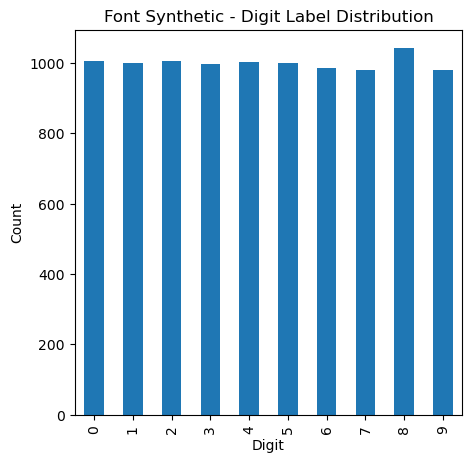

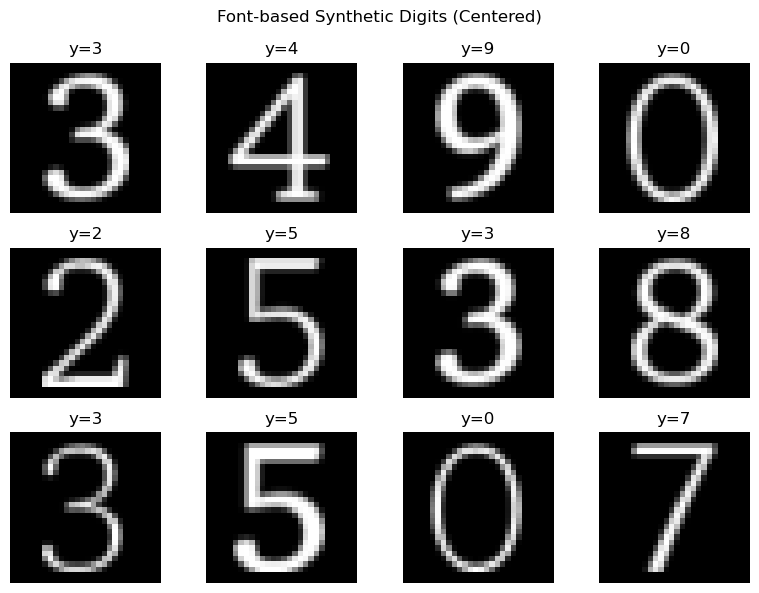

In [6]:
# ======================================
# Cell 5. Font-based synthetic (+10k)
# ======================================

FONT_PATHS = [
    os.path.join(RAW_FONTS_DIR, "MaruBuri-ExtraLight.ttf"),
    os.path.join(RAW_FONTS_DIR, "MaruBuri-Light.ttf"),
    os.path.join(RAW_FONTS_DIR, "MaruBuri-Regular.ttf"),
    os.path.join(RAW_FONTS_DIR, "MaruBuri-SemiBold.ttf"),
    os.path.join(RAW_FONTS_DIR, "MaruBuri-Bold.ttf"),
]

def render_digit_with_font(digit: int,
                           font_path: str,
                           img_size: int = 28) -> np.ndarray:
    """
    Render a single digit using a TrueType font and center it
    in a 28x28 canvas.

    Steps:
      1) Draw the digit on a larger canvas (e.g., 64x64).
      2) Find the tight bounding box of non-zero pixels.
      3) Crop to that box.
      4) Resize with margin and paste into the center of 28x28.

    This removes baseline bias so digits are not shifted downward.
    """
    # 1) large temporary canvas (to avoid clipping)
    BIG_SIZE = 64
    img_big = Image.new("L", (BIG_SIZE, BIG_SIZE), color=0)  # black background
    draw_big = ImageDraw.Draw(img_big)

    # choose font and size (larger than final 28x28)
    font_size = 48
    font = ImageFont.truetype(font_path, font_size)
    text = str(digit)

    # roughly center text on the big canvas
    # use textbbox (Pillow >= 8.0) instead of deprecated textsize
    bbox = draw_big.textbbox((0, 0), text, font=font)
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]
    x = (BIG_SIZE - w) // 2
    y = (BIG_SIZE - h) // 2
    draw_big.text((x, y), text, fill=255, font=font)

    # convert to array and find tight bbox of drawn pixels
    arr_big = np.array(img_big, dtype=np.float32)
    ys, xs = np.where(arr_big > 0)

    if len(xs) == 0 or len(ys) == 0:
        # in case something went wrong, return zero image
        return np.zeros((img_size, img_size), dtype=np.float32)

    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()

    # 2) crop tight bounding box
    crop = arr_big[y_min:y_max + 1, x_min:x_max + 1]  # (Hc, Wc)

    # 3) resize to fit into img_size with a small margin
    h_crop, w_crop = crop.shape
    # leave a 2-pixel margin on each side (so use img_size-4)
    target_side = img_size - 4
    scale = min(target_side / h_crop, target_side / w_crop)
    new_w = max(1, int(round(w_crop * scale)))
    new_h = max(1, int(round(h_crop * scale)))

    crop_img = Image.fromarray(crop)
    crop_resized = crop_img.resize((new_w, new_h), resample=Image.BILINEAR)

    # 4) paste resized digit onto 28x28 canvas, centered
    canvas = Image.new("L", (img_size, img_size), color=0)
    x_off = (img_size - new_w) // 2
    y_off = (img_size - new_h) // 2
    canvas.paste(crop_resized, (x_off, y_off))

    return np.array(canvas, dtype=np.float32)


def generate_font_synthetic(n_samples: int,
                            font_paths,
                            random_state: int = 202):
    """
    Generate n_samples synthetic digit images using multiple fonts.
    Digit labels are uniformly sampled from 0~9.
    Each rendered digit is centered using render_digit_with_font().
    """
    rng = np.random.default_rng(random_state)
    digits = rng.integers(0, 10, size=n_samples)

    X_syn = np.empty((n_samples, IMG_HEIGHT, IMG_WIDTH), dtype=np.float32)
    y_syn = digits.astype(np.int64)

    for i in range(n_samples):
        d = int(digits[i])
        font_path = rng.choice(font_paths)
        X_syn[i] = render_digit_with_font(d, font_path, img_size=IMG_HEIGHT)

    return X_syn, y_syn


# --- generate 10k font-based samples ---
X_font, y_font = generate_font_synthetic(
    n_samples=FONT_AUG_TARGET,
    font_paths=FONT_PATHS,
    random_state=202,
)
print("[INFO] Font synthetic shape:", X_font.shape)

# --- EDA: label distribution & samples (font) ---
font_label_counts = pd.Series(y_font).value_counts().sort_index()
print("\n[EDA] Digit label counts (font synthetic):")
print(font_label_counts)

plt.figure()
font_label_counts.plot(kind="bar")
plt.title("Font Synthetic - Digit Label Distribution")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()

def plot_font_examples(X, y, n=12):
    """
    Visual check for font-based synthetic digits.
    Digits should be centered vertically & horizontally.
    """
    idx = np.random.choice(len(X), size=n, replace=False)
    cols = 4
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(cols * 2, rows * 2))
    for k, i in enumerate(idx):
        plt.subplot(rows, cols, k + 1)
        plt.imshow(X[i], cmap="gray")
        plt.title(f"y={y[i]}")
        plt.axis("off")
    plt.suptitle("Font-based Synthetic Digits (Centered)")
    plt.tight_layout()
    plt.show()

plot_font_examples(X_font, y_font, n=12)

[INFO] Geometric augmented shape: (10000, 28, 28)

[EDA] Digit label counts (geom augmentation):
0     974
1    1125
2    1010
3     990
4    1012
5     872
6     989
7    1075
8     946
9    1007
Name: count, dtype: int64


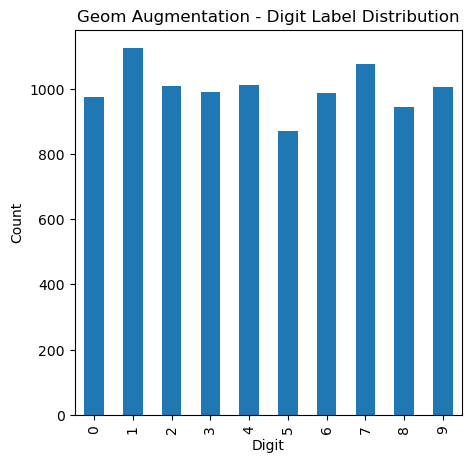

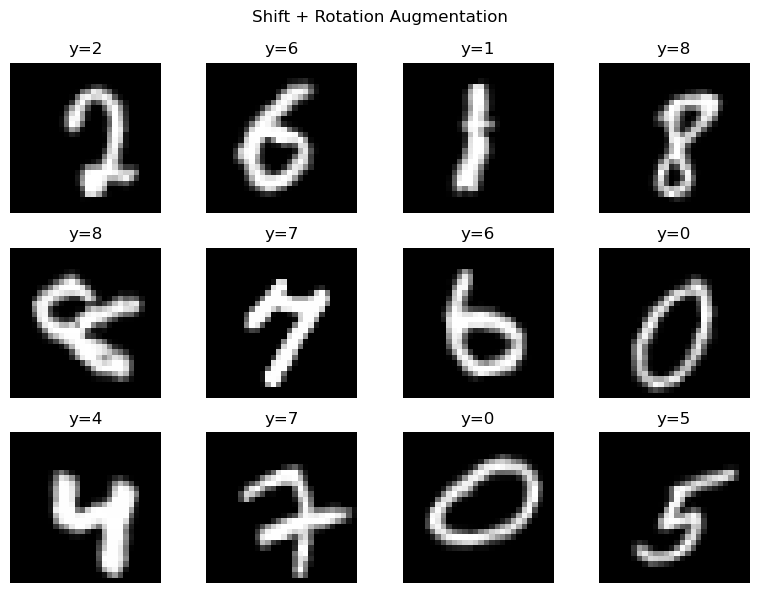

In [7]:
# ======================================
# Cell 6. Shift + rotation augmentation (+10k)
# ======================================

from scipy.ndimage import shift, rotate  # 다시 한 번 확실히 임포트

def augment_shift_rotation(
    X: np.ndarray,
    y: np.ndarray,
    n_aug: int,
    max_shift: int = 2,
    max_rot: float = 15.0,
    random_state: int = 303,
):
    """
    Create n_aug augmented images by applying random shift and rotation.

    - X: (N, 28, 28) grayscale images
    - y: (N,) digit labels
    - n_aug: number of augmented samples to generate
    - max_shift: max pixel shift in x/y direction (±max_shift)
    - max_rot: max rotation angle in degrees (uniform in [-max_rot, max_rot])

    Returns:
      X_aug: (n_aug, 28, 28) float32
      y_aug: (n_aug,) int64
    """
    rng = np.random.default_rng(random_state)
    N = len(X)

    X_aug = np.empty((n_aug, IMG_HEIGHT, IMG_WIDTH), dtype=np.float32)
    y_aug = np.empty((n_aug,), dtype=np.int64)

    for i in range(n_aug):
        idx = rng.integers(0, N)
        img = X[idx]

        # random shift
        dy = rng.integers(-max_shift, max_shift + 1)
        dx = rng.integers(-max_shift, max_shift + 1)
        shifted = shift(img, shift=(dy, dx), cval=0.0)

        # random rotation
        angle = rng.uniform(-max_rot, max_rot)
        rotated = rotate(
            shifted,
            angle=angle,
            reshape=False,
            cval=0.0,
            order=1,
        )

        X_aug[i] = rotated
        y_aug[i] = y[idx]

    return X_aug, y_aug


# --- generate 10k geometric augmented samples ---
X_geom, y_geom = augment_shift_rotation(
    X_raw,          # 원본 MNIST에서 샘플링
    y_raw,
    n_aug=GEOM_AUG_TARGET,
    max_shift=2,
    max_rot=15.0,
    random_state=303,
)

print("[INFO] Geometric augmented shape:", X_geom.shape)

# --- EDA: label distribution & sample visualization ---

geom_label_counts = pd.Series(y_geom).value_counts().sort_index()
print("\n[EDA] Digit label counts (geom augmentation):")
print(geom_label_counts)

plt.figure()
geom_label_counts.plot(kind="bar")
plt.title("Geom Augmentation - Digit Label Distribution")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()

def plot_geom_examples(X_aug, y_aug, n=12):
    """
    Visual check for shift+rotation augmented digits.
    """
    idx = np.random.choice(len(X_aug), size=n, replace=False)
    cols = 4
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(cols * 2, rows * 2))
    for k, i in enumerate(idx):
        plt.subplot(rows, cols, k + 1)
        plt.imshow(X_aug[i], cmap="gray")
        plt.title(f"y={y_aug[i]}")
        plt.axis("off")
    plt.suptitle("Shift + Rotation Augmentation")
    plt.tight_layout()
    plt.show()

plot_geom_examples(X_geom, y_geom, n=12)

[INFO] Total digits shape : (100000, 28, 28)
[INFO] Total labels shape : (100000,)
[INFO] Source array shape : (100000,)

[EDA] Digit label counts (all samples):
0     9841
1    11092
2     9978
3    10229
4     9841
5     9094
6     9903
7    10364
8     9804
9     9854
Name: count, dtype: int64


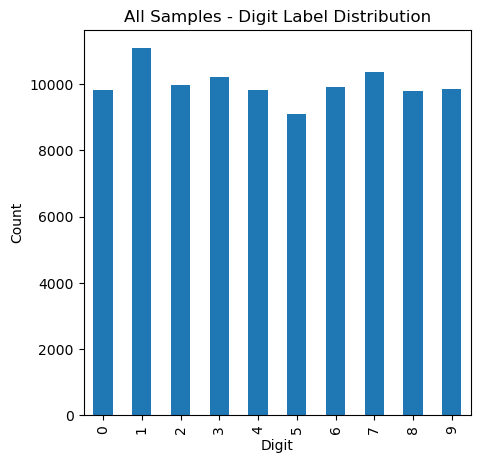


[EDA] Source distribution (raw / deskew / font / geom):
raw       60000
deskew    20000
font      10000
geom      10000
Name: count, dtype: int64


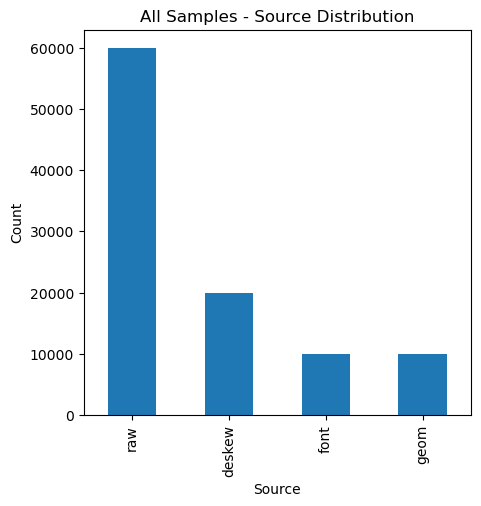


[EDA] Crosstab (digit vs source):
col_0  deskew  font  geom   raw
row_0                          
0        1938  1006   974  5923
1        2226   999  1125  6742
2        2004  1006  1010  5958
3        2111   997   990  6131
4        1983  1004  1012  5842
5        1800  1001   872  5421
6        2011   985   989  5918
7        2045   979  1075  6265
8        1965  1042   946  5851
9        1917   981  1007  5949


In [8]:
# ======================================
# Cell 7. Merge all sources → 100k
# ======================================

# Safety check: make sure all augmentation arrays exist
for name in ["X_raw", "X_deskew", "X_font", "X_geom",
             "y_raw", "y_deskew", "y_font", "y_geom"]:
    if name not in globals():
        raise RuntimeError(f"[ERROR] {name} is not defined. "
                           f"Run Cells 3~6 in order before this cell.")

# Ensure all are float32 for consistency
X_raw    = X_raw.astype(np.float32)
X_deskew = X_deskew.astype(np.float32)
X_font   = X_font.astype(np.float32)
X_geom   = X_geom.astype(np.float32)

# Concatenate images and labels
X_all = np.concatenate([X_raw, X_deskew, X_font, X_geom], axis=0)
y_all = np.concatenate([y_raw, y_deskew, y_font, y_geom], axis=0)

# Track source type for each sample (raw / deskew / font / geom)
source_tags = (
    ["raw"]    * len(X_raw)    +
    ["deskew"] * len(X_deskew) +
    ["font"]   * len(X_font)   +
    ["geom"]   * len(X_geom)
)
source_all = np.array(source_tags)

print("[INFO] Total digits shape :", X_all.shape)
print("[INFO] Total labels shape :", y_all.shape)
print("[INFO] Source array shape :", source_all.shape)

# Sanity check: total count == TARGET_TOTAL_SAMPLES
assert X_all.shape[0] == TARGET_TOTAL_SAMPLES, \
    f"Expected {TARGET_TOTAL_SAMPLES}, got {X_all.shape[0]}"
assert y_all.shape[0] == TARGET_TOTAL_SAMPLES
assert source_all.shape[0] == TARGET_TOTAL_SAMPLES

# --- EDA: overall label & source distribution ---

label_counts_all = pd.Series(y_all).value_counts().sort_index()
print("\n[EDA] Digit label counts (all samples):")
print(label_counts_all)

plt.figure()
label_counts_all.plot(kind="bar")
plt.title("All Samples - Digit Label Distribution")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()

source_counts = pd.Series(source_all).value_counts()
print("\n[EDA] Source distribution (raw / deskew / font / geom):")
print(source_counts)

plt.figure()
source_counts.plot(kind="bar")
plt.title("All Samples - Source Distribution")
plt.xlabel("Source")
plt.ylabel("Count")
plt.show()

crosstab_source = pd.crosstab(y_all, source_all)
print("\n[EDA] Crosstab (digit vs source):")
print(crosstab_source)

[INFO] fg labels shape: (100000,)
[INFO] bg labels shape: (100000,)
[INFO] any fg == bg?  : False

[EDA] Foreground color label counts:
0    14343
1    14251
2    14231
3    14444
4    14194
5    14394
6    14143
Name: count, dtype: int64

[EDA] Background color label counts:
0    14288
1    14117
2    14386
3    14328
4    14620
5    14257
6    14004
Name: count, dtype: int64


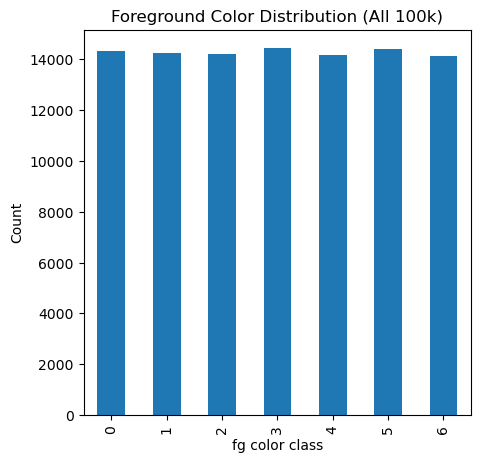

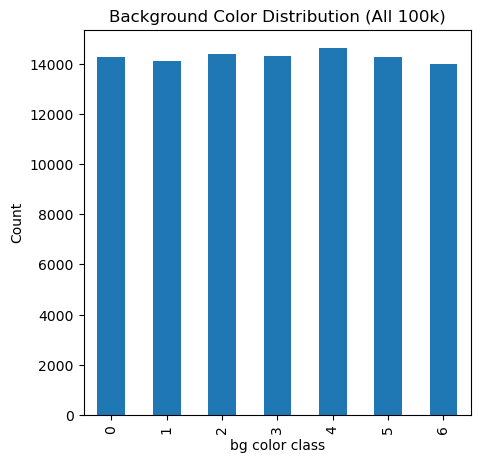


[EDA] Crosstab (fg vs bg):
col_0     0     1     2     3     4     5     6
row_0                                          
0         0  2380  2429  2318  2421  2391  2404
1      2330     0  2380  2486  2403  2378  2274
2      2433  2375     0  2360  2420  2366  2277
3      2409  2355  2385     0  2521  2390  2384
4      2373  2351  2410  2318     0  2344  2398
5      2411  2338  2456  2471  2451     0  2267
6      2332  2318  2326  2375  2404  2388     0
[INFO] Colored RGB shape: (100000, 28, 28, 3)
[INFO] Flattened shape  : (100000, 2352)


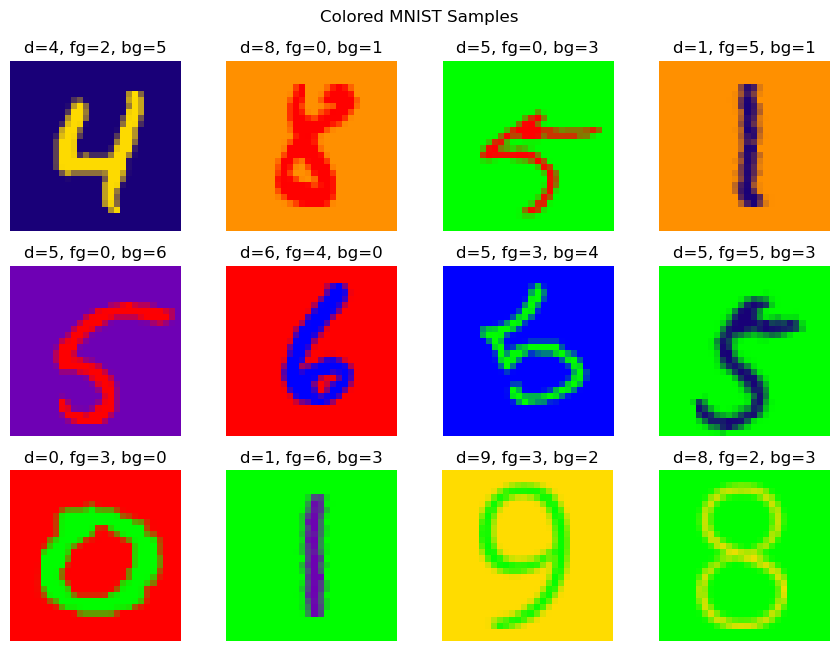

In [9]:
# ======================================
# Cell 8. fg/bg color labels + colorize
# ======================================

def assign_fg_bg_labels(n_samples: int,
                        n_colors: int,
                        random_state: int = 777):
    """
    Randomly assign foreground/background color labels with fg != bg.
    """
    rng = np.random.default_rng(random_state)
    fg = rng.integers(0, n_colors, size=n_samples)
    bg = rng.integers(0, n_colors, size=n_samples)

    same_mask = fg == bg
    while np.any(same_mask):
        bg[same_mask] = rng.integers(0, n_colors, size=same_mask.sum())
        same_mask = fg == bg

    return fg.astype(np.int64), bg.astype(np.int64)


y_fg_all, y_bg_all = assign_fg_bg_labels(
    n_samples=X_all.shape[0],
    n_colors=N_COLORS,
    random_state=777,
)

print("[INFO] fg labels shape:", y_fg_all.shape)
print("[INFO] bg labels shape:", y_bg_all.shape)
print("[INFO] any fg == bg?  :", np.any(y_fg_all == y_bg_all))

# --- EDA: fg/bg label distribution ---
fg_counts = pd.Series(y_fg_all).value_counts().sort_index()
bg_counts = pd.Series(y_bg_all).value_counts().sort_index()

print("\n[EDA] Foreground color label counts:")
print(fg_counts)
print("\n[EDA] Background color label counts:")
print(bg_counts)

plt.figure()
fg_counts.plot(kind="bar")
plt.title("Foreground Color Distribution (All 100k)")
plt.xlabel("fg color class")
plt.ylabel("Count")
plt.show()

plt.figure()
bg_counts.plot(kind="bar")
plt.title("Background Color Distribution (All 100k)")
plt.xlabel("bg color class")
plt.ylabel("Count")
plt.show()

fg_bg_ct = pd.crosstab(y_fg_all, y_bg_all)
print("\n[EDA] Crosstab (fg vs bg):")
print(fg_bg_ct)


def colorize_with_palette(X_gray: np.ndarray,
                          fg_labels: np.ndarray,
                          bg_labels: np.ndarray,
                          palette: np.ndarray):
    """
    Convert grayscale digits (N, H, W) into RGB images using a discrete palette.
    Returns both RGB images and flattened features.
    """
    N = X_gray.shape[0]
    X_rgb = np.zeros((N, IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
    X_norm = X_gray / 255.0  # normalize to [0,1] for blending

    for i in range(N):
        fg_color = palette[fg_labels[i]].astype(np.float32)
        bg_color = palette[bg_labels[i]].astype(np.float32)

        img_rgb = np.tile(bg_color[None, None, :], (IMG_HEIGHT, IMG_WIDTH, 1))
        alpha = X_norm[i][..., None]
        img_rgb = alpha * fg_color + (1.0 - alpha) * img_rgb

        X_rgb[i] = img_rgb.clip(0, 255).astype(np.uint8)

    X_flat = X_rgb.reshape(N, -1).astype(np.float32)
    return X_rgb, X_flat


X_rgb_all, X_flat_all = colorize_with_palette(
    X_gray=X_all,
    fg_labels=y_fg_all,
    bg_labels=y_bg_all,
    palette=COLOR_PALETTE,
)

print("[INFO] Colored RGB shape:", X_rgb_all.shape)   # (100000, 28, 28, 3)
print("[INFO] Flattened shape  :", X_flat_all.shape)  # (100000, 2352)

def plot_colored_samples(X_rgb, y_digit, y_fg, y_bg, n=12):
    """
    Visual sanity check for colored samples.
    """
    idx = np.random.choice(len(X_rgb), size=n, replace=False)
    cols = 4
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(cols * 2.2, rows * 2.2))
    for k, i in enumerate(idx):
        plt.subplot(rows, cols, k + 1)
        plt.imshow(X_rgb[i])
        plt.title(f"d={y_digit[i]}, fg={y_fg[i]}, bg={y_bg[i]}")
        plt.axis("off")
    plt.suptitle("Colored MNIST Samples")
    plt.tight_layout()
    plt.show()

plot_colored_samples(X_rgb_all, y_all, y_fg_all, y_bg_all, n=12)

[INFO] Final split shapes (train / val only):
X_train       : (80000, 2352)
X_val         : (20000, 2352)
y_digit_train : (80000,)
y_digit_val   : (20000,)
y_fg_train    : (80000,)
y_fg_val      : (20000,)
y_bg_train    : (80000,)
y_bg_val      : (20000,)
source_train  : (80000,)
source_val    : (20000,)

[EDA] Digit distribution - train:
0    7873
1    8874
2    7982
3    8183
4    7873
5    7275
6    7923
7    8291
8    7843
9    7883
Name: count, dtype: int64
[EDA] Digit distribution - val:
0    1968
1    2218
2    1996
3    2046
4    1968
5    1819
6    1980
7    2073
8    1961
9    1971
Name: count, dtype: int64


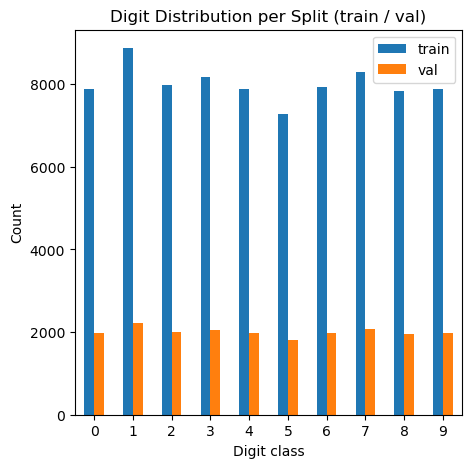


[EDA] Foreground Color distribution - train:
0    11428
1    11391
2    11323
3    11589
4    11385
5    11547
6    11337
Name: count, dtype: int64
[EDA] Foreground Color distribution - val:
0    2915
1    2860
2    2908
3    2855
4    2809
5    2847
6    2806
Name: count, dtype: int64


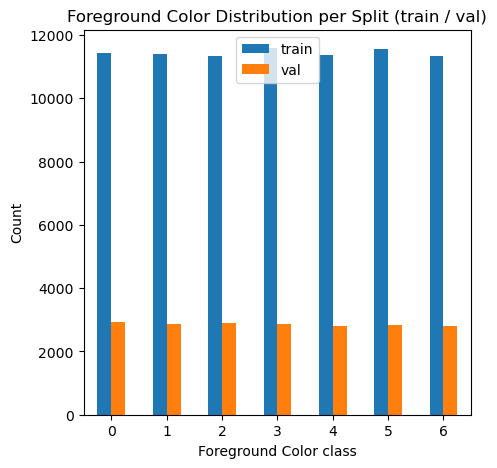


[EDA] Background Color distribution - train:
0    11411
1    11299
2    11570
3    11472
4    11619
5    11408
6    11221
Name: count, dtype: int64
[EDA] Background Color distribution - val:
0    2877
1    2818
2    2816
3    2856
4    3001
5    2849
6    2783
Name: count, dtype: int64


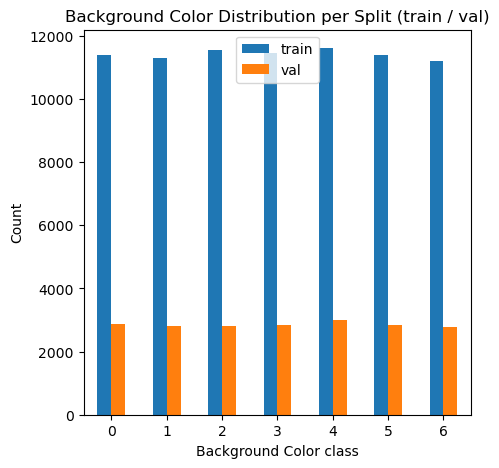


[EDA] Source distribution - train:
raw       48054
deskew    16027
geom       7962
font       7957
Name: count, dtype: int64

[EDA] Source distribution - val:
raw       11946
deskew     3973
font       2043
geom       2038
Name: count, dtype: int64


In [10]:
# ======================================
# Cell 9. Train / Val split (80:20, no test)
# ======================================

X_train, X_val, y_digit_train, y_digit_val, y_fg_train, y_fg_val, y_bg_train, y_bg_val, source_train, source_val = train_test_split(
    X_flat_all,
    y_all,
    y_fg_all,
    y_bg_all,
    source_all,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y_all,  # stratify on digit labels
)

print("[INFO] Final split shapes (train / val only):")
print("X_train       :", X_train.shape)
print("X_val         :", X_val.shape)
print("y_digit_train :", y_digit_train.shape)
print("y_digit_val   :", y_digit_val.shape)
print("y_fg_train    :", y_fg_train.shape)
print("y_fg_val      :", y_fg_val.shape)
print("y_bg_train    :", y_bg_train.shape)
print("y_bg_val      :", y_bg_val.shape)
print("source_train  :", source_train.shape)
print("source_val    :", source_val.shape)

def plot_split_distribution_2way(y_train, y_val, title_prefix="Digit"):
    """
    Check that train/val splits preserve class balance.
    """
    train_counts = pd.Series(y_train).value_counts().sort_index()
    val_counts   = pd.Series(y_val).value_counts().sort_index()

    print(f"\n[EDA] {title_prefix} distribution - train:")
    print(train_counts)
    print(f"[EDA] {title_prefix} distribution - val:")
    print(val_counts)

    idx = sorted(set(train_counts.index) | set(val_counts.index))
    df = pd.DataFrame({
        "train": train_counts.reindex(idx),
        "val":   val_counts.reindex(idx),
    })

    df.plot(kind="bar")
    plt.title(f"{title_prefix} Distribution per Split (train / val)")
    plt.xlabel(f"{title_prefix} class")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.show()

# Check digit / fg / bg balance
plot_split_distribution_2way(y_digit_train, y_digit_val, "Digit")
plot_split_distribution_2way(y_fg_train,    y_fg_val,    "Foreground Color")
plot_split_distribution_2way(y_bg_train,    y_bg_val,    "Background Color")

# EDA: source distribution per split (raw / deskew / font / geom)
print("\n[EDA] Source distribution - train:")
print(pd.Series(source_train).value_counts())

print("\n[EDA] Source distribution - val:")
print(pd.Series(source_val).value_counts())

In [11]:
# ======================================
# Cell 10. Save final NPZ (train/val only)
# ======================================

np.savez_compressed(
    SAVE_PATH,
    # features
    X_train=X_train,
    X_val=X_val,

    # labels: digit / foreground / background
    y_digit_train=y_digit_train,
    y_digit_val=y_digit_val,
    y_fg_train=y_fg_train,
    y_fg_val=y_fg_val,
    y_bg_train=y_bg_train,
    y_bg_val=y_bg_val,

    # where each sample came from (raw / deskew / font / geom)
    source_train=source_train,
    source_val=source_val,

    # meta
    color_palette=COLOR_PALETTE,
    random_seed=RANDOM_SEED,
    deskew_aug_target=DESKEW_AUG_TARGET,
    font_aug_target=FONT_AUG_TARGET,
    geom_aug_target=GEOM_AUG_TARGET,
)

print(f"[INFO] Saved processed colored MNIST (train/val only) to: {SAVE_PATH}")

[INFO] Saved processed colored MNIST (train/val only) to: c:\Users\CHOI\colored-mnist-classification\notebooks\data\processed\colored_mnist\colored_mnist_100k_train_val.npz


[INFO] Sampling 3000 points for t-SNE...
[INFO] Running t-SNE (this may take a moment)...
[INFO] t-SNE finished.


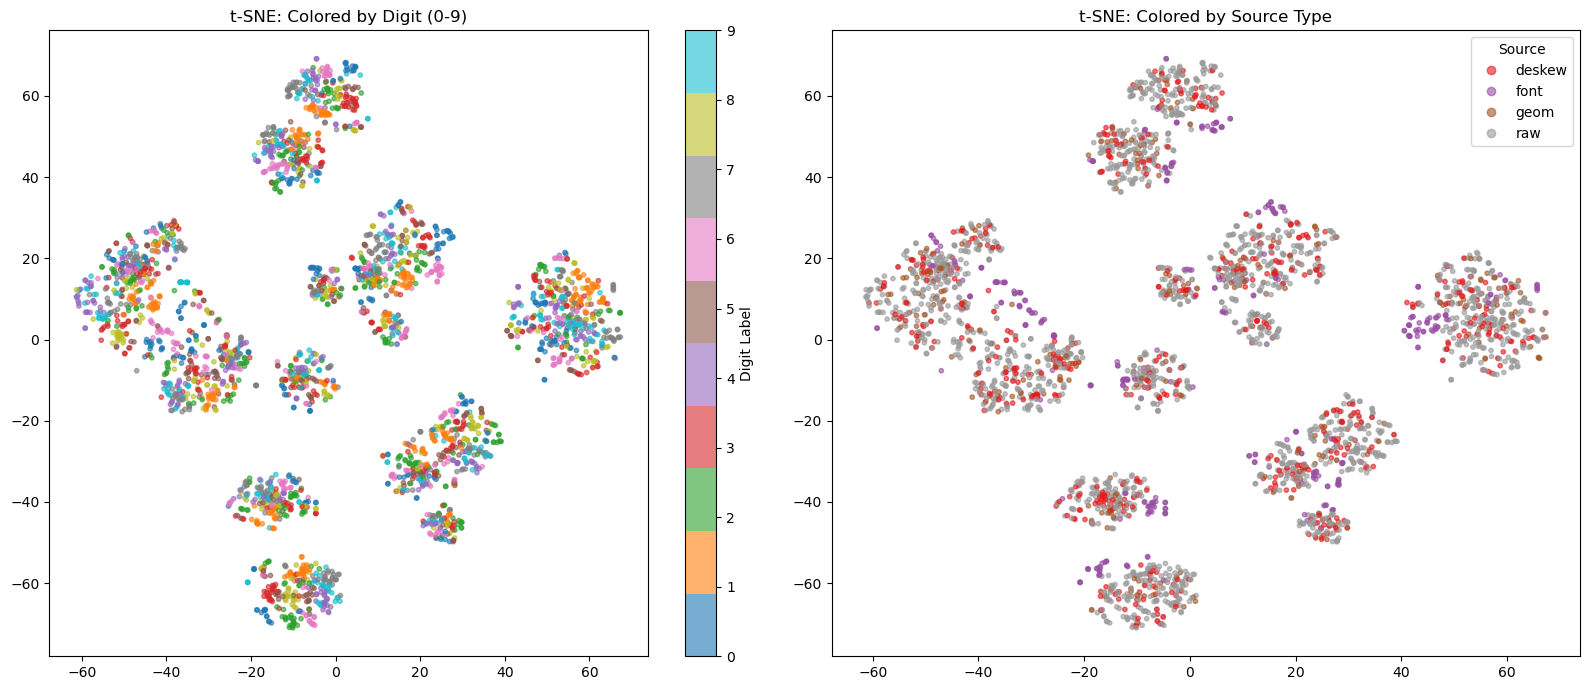

In [12]:
# ======================================
# Cell 11. t-SNE Visualization (Data Quality Check)
# ======================================
from sklearn.manifold import TSNE
import matplotlib.cm as cm

def plot_tsne_check(X, y_digit, y_source, n_samples=3000, random_state=42):
    print(f"[INFO] Sampling {n_samples} points for t-SNE...")

    # 1. Random Sampling (너무 많으면 오래 걸리므로 일부만 추출)
    rng = np.random.default_rng(random_state)
    N = len(X)
    idx = rng.choice(N, size=min(N, n_samples), replace=False)

    X_sample = X[idx]
    y_digit_sample = y_digit[idx]
    y_source_sample = y_source[idx]

    # 2. Run t-SNE
    print("[INFO] Running t-SNE (this may take a moment)...")
    tsne = TSNE(n_components=2, perplexity=30, random_state=random_state, init='pca', learning_rate='auto')
    X_embedded = tsne.fit_transform(X_sample)
    print("[INFO] t-SNE finished.")

    # 3. Plotting (Side by Side)
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # Plot 1: Color by Digit (0~9)
    scatter1 = axes[0].scatter(
        X_embedded[:, 0], X_embedded[:, 1],
        c=y_digit_sample, cmap='tab10', alpha=0.6, s=10
    )
    axes[0].set_title("t-SNE: Colored by Digit (0-9)")
    plt.colorbar(scatter1, ax=axes[0], ticks=range(10), label="Digit Label")

    # Plot 2: Color by Source (raw, deskew, font, geom)
    # 문자열 라벨을 숫자로 변환
    unique_sources = np.unique(y_source_sample)
    source_to_int = {s: i for i, s in enumerate(unique_sources)}
    c_source = [source_to_int[s] for s in y_source_sample]

    scatter2 = axes[1].scatter(
        X_embedded[:, 0], X_embedded[:, 1],
        c=c_source, cmap='Set1', alpha=0.6, s=10
    )
    axes[1].set_title("t-SNE: Colored by Source Type")

    # Legend for sources
    handles, _ = scatter2.legend_elements()
    axes[1].legend(handles, unique_sources, title="Source")

    plt.tight_layout()
    plt.show()

# 실행 (Train 데이터의 분포 확인)
plot_tsne_check(X_train, y_digit_train, source_train, n_samples=3000)

[INFO] Sampling 3000 points for original MNIST t-SNE...
[INFO] Running t-SNE on original MNIST...
[INFO] t-SNE finished.


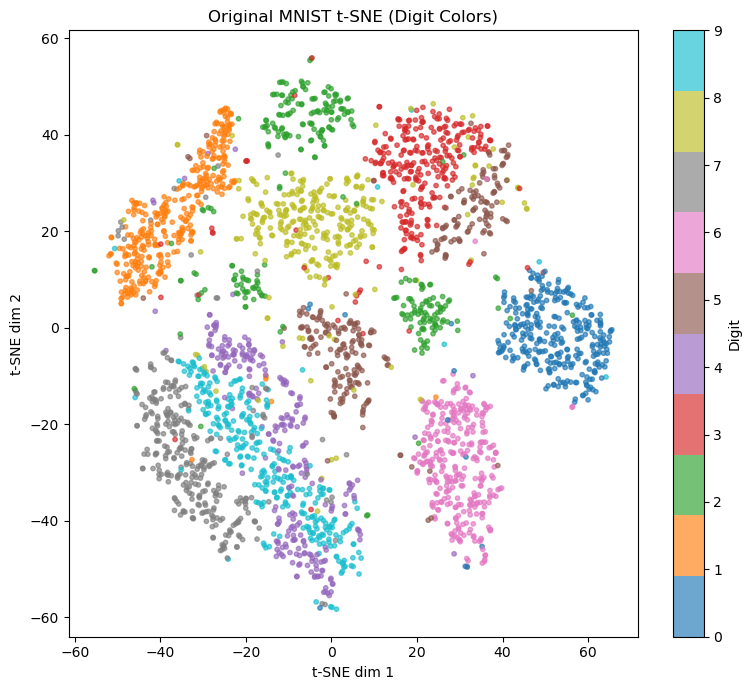

In [13]:
# ======================================
# Cell 11-A. Original MNIST t-SNE
# ======================================
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne_original_mnist(X_raw, y_raw, n_samples=3000, random_state=42):
    print(f"[INFO] Sampling {n_samples} points for original MNIST t-SNE...")

    # 1. Random sampling
    rng = np.random.default_rng(random_state)
    N = len(X_raw)
    idx = rng.choice(N, size=min(N, n_samples), replace=False)

    X_sample = X_raw[idx]              # shape: (n, 28, 28)
    y_sample = y_raw[idx]

    # Flatten: 28x28 → 784
    X_flat = X_sample.reshape(len(X_sample), -1)

    # 2. Run t-SNE
    print("[INFO] Running t-SNE on original MNIST...")
    tsne = TSNE(
        n_components=2,
        perplexity=30,
        random_state=random_state,
        init='pca',
        learning_rate='auto'
    )
    X_embedded = tsne.fit_transform(X_flat)
    print("[INFO] t-SNE finished.")

    # 3. Plot
    plt.figure(figsize=(8, 7))
    scatter = plt.scatter(
        X_embedded[:, 0], X_embedded[:, 1],
        c=y_sample, cmap="tab10", alpha=0.65, s=10
    )
    plt.colorbar(scatter, ticks=range(10), label="Digit")
    plt.title("Original MNIST t-SNE (Digit Colors)")
    plt.xlabel("t-SNE dim 1")
    plt.ylabel("t-SNE dim 2")
    plt.tight_layout()
    plt.show()

# 실행
plot_tsne_original_mnist(X_raw, y_raw, n_samples=3000)


[INFO] Unique sources (train): ['deskew' 'font' 'geom' 'raw']
[INFO] source=deskew : 16027 samples
[INFO] source=font   : 7957 samples
[INFO] source=geom   : 7962 samples
[INFO] source=raw    : 48054 samples

[INFO] Pairwise centroid distance matrix (L2, train only):
[[ 0.       53.85253  34.242065 67.12421 ]
 [53.85253   0.       39.546932 39.793533]
 [34.242065 39.546932  0.       55.50965 ]
 [67.12421  39.793533 55.50965   0.      ]]


,deskew,font,geom,raw
deskew,0.000000,53.852531,34.242065,67.124207
font,53.852531,0.000000,39.546932,39.793533
geom,34.242065,39.546932,0.000000,55.509651
raw,67.124207,39.793533,55.509651,0.000000


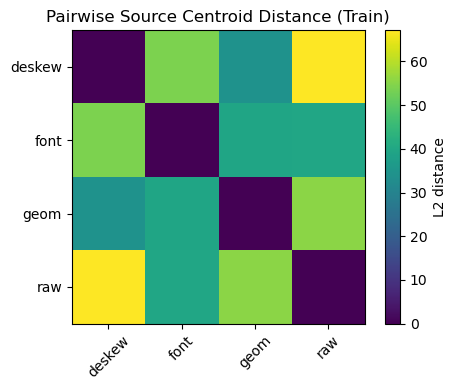

In [14]:
# ======================================
# Cell 12. Source-wise centroid & pairwise distance (L2, train only)
# ======================================

unique_src = np.unique(source_train)
print("[INFO] Unique sources (train):", unique_src)

centroids = {}
for s in unique_src:
    idx = np.where(source_train == s)[0]
    centroids[s] = X_train[idx].mean(axis=0)
    print(f"[INFO] source={s:6s} : {len(idx)} samples")

K = len(unique_src)
dist_matrix = np.zeros((K, K), dtype=np.float32)

for i, si in enumerate(unique_src):
    for j, sj in enumerate(unique_src):
        diff = centroids[si] - centroids[sj]
        dist_matrix[i, j] = np.sqrt(np.sum(diff * diff))

print("\n[INFO] Pairwise centroid distance matrix (L2, train only):")
print(dist_matrix)

df_dist = pd.DataFrame(dist_matrix, index=unique_src, columns=unique_src)
display(df_dist)

plt.figure(figsize=(5, 4))
plt.imshow(dist_matrix, interpolation="nearest")
plt.colorbar(label="L2 distance")
plt.xticks(np.arange(K), unique_src, rotation=45)
plt.yticks(np.arange(K), unique_src)
plt.title("Pairwise Source Centroid Distance (Train)")
plt.tight_layout()
plt.show()


[INFO] #font samples (train): 7957
[INFO] Subsampled to 5000 for t-SNE.
[INFO] Running t-SNE on font subset (train)...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.006s...


c:\Users\CHOI\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 5000 samples in 1.792s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 776.857250
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.844395
[t-SNE] KL divergence after 1000 iterations: 0.175571
[INFO] t-SNE finished for font subset (train).


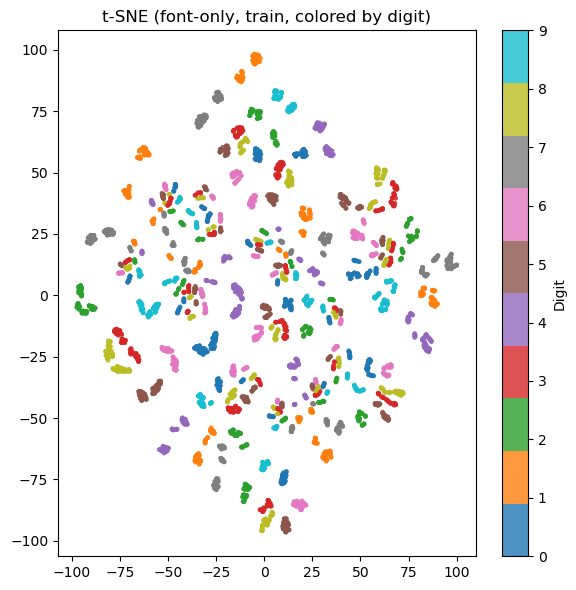

In [15]:
# ======================================
# Cell 13. t-SNE for font-only subset (train only)
# ======================================

from sklearn.manifold import TSNE

FONT_LABEL = "font"

font_idx = np.where(source_train == FONT_LABEL)[0]
print("[INFO] #font samples (train):", len(font_idx))

MAX_TSNE_SAMPLES = 5000
if len(font_idx) > MAX_TSNE_SAMPLES:
    font_idx = np.random.choice(font_idx, size=MAX_TSNE_SAMPLES, replace=False)
    print(f"[INFO] Subsampled to {len(font_idx)} for t-SNE.")

X_font_train   = X_train[font_idx]
y_font_digits  = y_digit_train[font_idx]

tsne_font = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    n_iter=1000,
    verbose=1,
    random_state=RANDOM_SEED,
)

print("[INFO] Running t-SNE on font subset (train)...")
X_font_tsne = tsne_font.fit_transform(X_font_train)
print("[INFO] t-SNE finished for font subset (train).")

plt.figure(figsize=(6, 6))
sc = plt.scatter(
    X_font_tsne[:, 0],
    X_font_tsne[:, 1],
    c=y_font_digits,
    cmap="tab10",
    s=6,
    alpha=0.8,
)
plt.colorbar(sc, ticks=range(10), label="Digit")
plt.title("t-SNE (font-only, train, colored by digit)")
plt.tight_layout()
plt.show()


[INFO] Digit–Source count table (train):


col_0,deskew,font,geom,raw
row_0,,,,
0,1537,807,786,4743
1,1795,786,893,5400
2,1593,788,810,4791
3,1719,807,780,4877
4,1578,800,801,4694
5,1443,791,697,4344
6,1599,787,787,4750
7,1643,771,852,5025
8,1575,829,752,4687


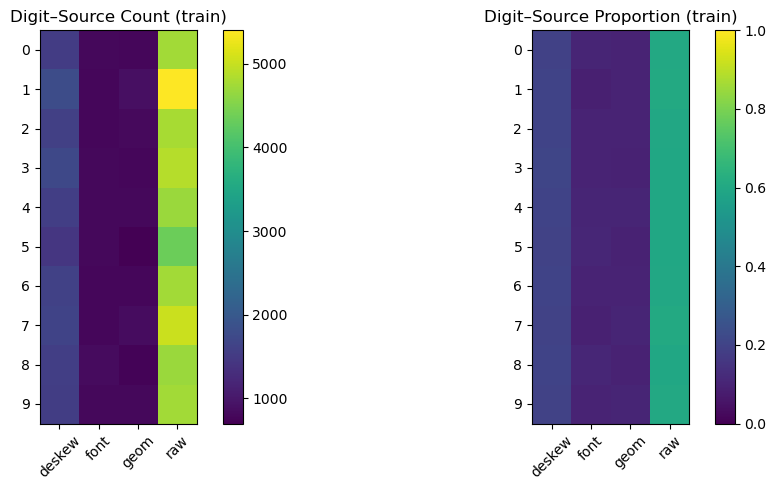

In [16]:
# ======================================
# Cell 14. Digit–Source distribution heatmap (train only)
# ======================================

ctab_train = pd.crosstab(y_digit_train, source_train)
print("[INFO] Digit–Source count table (train):")
display(ctab_train)

digits  = ctab_train.index.astype(str).tolist()
sources = ctab_train.columns.tolist()

count_matrix = ctab_train.values.astype(np.float32)
row_sums = count_matrix.sum(axis=1, keepdims=True)
prop_matrix = count_matrix / np.maximum(row_sums, 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# (1) raw count heatmap
im0 = axes[0].imshow(count_matrix, interpolation="nearest")
axes[0].set_xticks(np.arange(len(sources)))
axes[0].set_xticklabels(sources, rotation=45)
axes[0].set_yticks(np.arange(len(digits)))
axes[0].set_yticklabels(digits)
axes[0].set_title("Digit–Source Count (train)")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# (2) row-normalized proportion heatmap
im1 = axes[1].imshow(prop_matrix, interpolation="nearest", vmin=0, vmax=1)
axes[1].set_xticks(np.arange(len(sources)))
axes[1].set_xticklabels(sources, rotation=45)
axes[1].set_yticks(np.arange(len(digits)))
axes[1].set_yticklabels(digits)
axes[1].set_title("Digit–Source Proportion (train)")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()
